# MainQuest03

### 일시 2024.09.30
### 작성자 김우찬

#### 채점 기준
- 프로젝트 제출 : 1점
- 루브릭 : 4점
    - 의료영상을 처리하는 CNN 기반 베이스 모델이 잘 구현되었다 : 1점
    - 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교 : 1점
    - 모델 구조 변경을 통해 베이스 모델과의 성능 비교 : 1점
    - ResNet-18 모델을 구현하고 학습 성공 : 1점
- 보고서 양식 : 개요, 목차, 주석 및 의견, summary, 회고, reference 등
    - 포함되어있지 않을 경우 감점 1점


## Report
1. 개요
    - 주어진 과제 채점 기준의 가장 기초적인 관점에서는 모두 학습에 성공하였던 것 같습니다.
    - 하지만, augmentation, 구조 변경, resnet-18 과 원래 데이터와의 비교시 그래프를 겹쳐 만들고 하면 좋았겠지만, 시간과 학습능력이 부족하여 만들 수 없었습니다..
    
2. 목차
    1. 노드 2 : 기본 데이터 출력
        - Epoch 10번으로 출력
    2. 노드 3 : Data Augmentation 기법을 사용해서 베이스 모델과의 성능 비교
        - Epoch 15번으로 출력
        - 상하좌우 밝기 등 변경 성공 
        - 성능 비교는 출력 전후로 마크다운으로 표기함
    3. 모델 구조 변경하여 베이스 모델과의 성능 비교
        - BatchNormalization을 빼고 Dropout으로 변경하여 성능 비교함
        - 성능 비교는 출력 전후로 마크다운으로 표기함        
    4. Resnet-18 모델을 구현하고 학습 성공
        - 학습 성공
3. 주석 및 의견
    - 각 코드, 함수 등에 직접 주석, 의견을 달았습니다.
4. Summary
    - 어렵다 어려워
5. 회고
    - 솔직히 말하면... 이렇게 하는 것이 무슨 의미가 있나 싶다...
6. Reference 
    - 참고 블로그 : https://meissa.tistory.com/54?category=938854
    - ChatGPT
    - LMS
7. 기타
- 

# 1. 노드 2 : 기본 데이터 출력

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

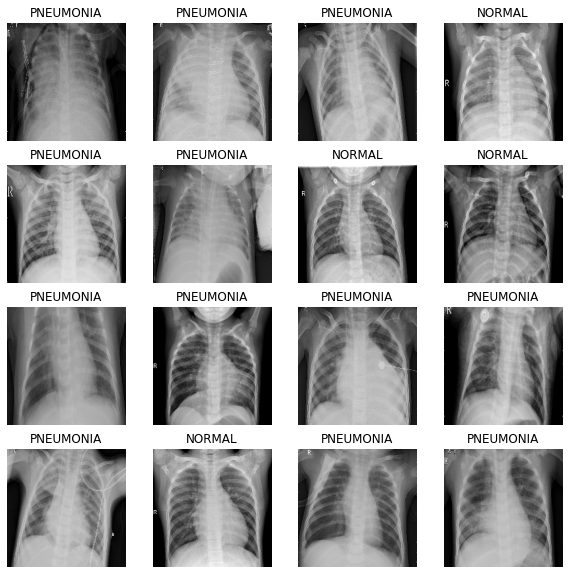

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [20]:
with tf.device('/GPU:0'): # GPU를 사용하는 명령어인듯, 하지 않는 것보다 빠르게 출력됨
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ] # metrics를 여러개 보겠다!
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 99s 210ms/step - loss: 0.3566 - accuracy: 0.8295 - precision: 0.9579 - recall: 0.8062 - val_loss: 0.7199 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 57s 218ms/step - loss: 0.2165 - accuracy: 0.9162 - precision: 0.9719 - recall: 0.9138 - val_loss: 1.6518 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 207ms/step - loss: 0.2071 - accuracy: 0.9234 - precision: 0.9775 - recall: 0.9185 - val_loss: 0.2449 - val_accuracy: 0.8798 - val_precision: 0.8591 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 210ms/step - loss: 0.1631 - accuracy: 0.9375 - precision: 0.9801 - recall: 0.9349 - val_loss: 0.0883 - val_accuracy: 0.9702 - val_precision: 0.9766 - val_recall: 0.9830
Epoch 5/10
261/261 [==============================] - 56s 215ms/step - loss: 0.1738 - accura

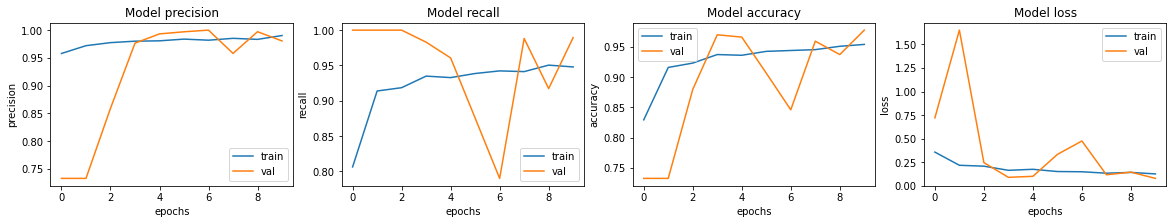

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 0.8175 - accuracy: 0.7708 - precision: 0.7343 - recall: 0.9923
Loss: 0.8174771070480347,
Accuracy: 0.7708333134651184,
Precision: 0.7343453764915466,
Recall: 0.9923076629638672


In [8]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import random, math
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [9]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# Epoch는 맘먹고 15회로 증가, Batch_size도 일단 15회로 두겠음
BATCH_SIZE = 15
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


In [10]:
# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드 활용
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 별 개수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [11]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [14]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [15]:
# 정상적인 이미지와 폐렴 이미지의 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [16]:
# 배치처리 작업을 효율적으로 하기위한 slices Dataset만들기 작업
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [17]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [20]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [22]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [23]:
# num_parallel_calls를 써주면 더 빠른 전처리가 가능
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


# 2. 노드 3 : Data Augmentation 기법을 사용해서 베이스 모델과의 성능 비교

In [46]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [47]:
import tensorflow # 텐서플로우 버전 확인

print(tensorflow.__version__)

2.6.0


In [48]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# Epoch는 맘먹고 15회로 증가, Batch_size도 일단 15회로 두겠음
BATCH_SIZE = 15
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


In [49]:
# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드 활용
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 별 개수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [50]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [51]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [52]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있음
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있음
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 정상보다 폐렴 데이터가 3배정도 더 많음 
- Balance 조정 필요

In [53]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [54]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [55]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [56]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [57]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다.
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줍니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지가 잘 리사이즈 되었는지, 라벨 잘 들어갔는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
# 데이터 갯수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## Data Augmentation

In [16]:
# Data Augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.    
    image = tf.image.random_flip_up_down(image) # 좌우 반전 외에 다른 항목들 추가. 1. 랜덤하게 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3)     # 2. 랜덤하게 밝기 조정    
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)     # 3. 랜덤하게 대비 조정
    return image,label
# 크기조절을 넣었더니 180,180 사이즈에서 변환되어서인지 오류가 발생하였음.

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # 복잡한 augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [17]:
image_batch, label_batch = next(iter(train_ds))
print("Image batch shape:", image_batch.shape)
print("Label batch shape:", label_batch.shape)

Image batch shape: (15, 180, 180, 3)
Label batch shape: (15,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

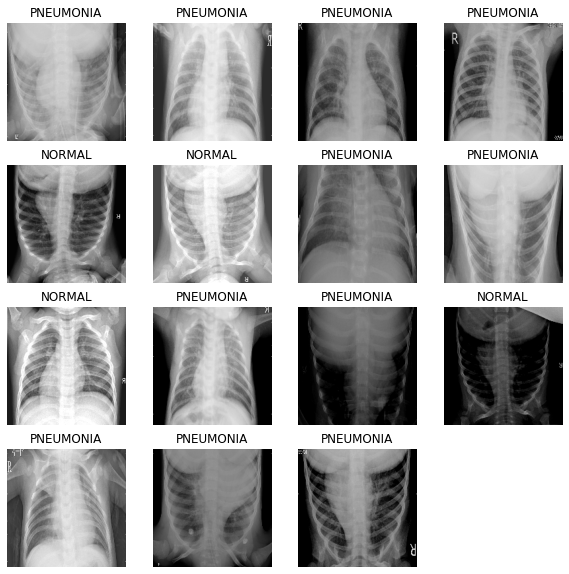

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
# 상하좌우반전, 밝기 변화 등 잘 나왔습니다.

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

## 동일한 Epoch로 비교
- Data augmentation 없는 것(10번 epoch) : 
Epoch 10/10
261/261 [==============================] - 50s 192ms/step - loss: 0.1248 - accuracy: 0.9543 - precision: 0.9903 - recall: 0.9479 - val_loss: 0.0773 - val_accuracy: 0.9779 - val_precision: 0.9805 - val_recall: 0.9895

- 이번 Data augmentation 10번 Epoch 기준 :
Epoch 10/15
279/279 [==============================] - 50s 179ms/step - loss: 0.2086 - accuracy: 0.9135 - precision: 0.9738 - recall: 0.9082 - val_loss: 0.1374 - val_accuracy: 0.9488 - val_precision: 0.9586 - val_recall: 0.9724

- 동일한 epoch로 비교시 accuracy, precision 감소...?
- 증강 적용한 데이터의 최종 epoch로 비교시 13번 이후로 val_accuracy 감소, 과대적합 의심.

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
279/279 [==============================] - 79s 200ms/step - loss: 0.6055 - accuracy: 0.6877 - precision: 0.8897 - recall: 0.6626 - val_loss: 0.5810 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/15
279/279 [==============================] - 51s 185ms/step - loss: 0.3650 - accuracy: 0.8356 - precision: 0.9553 - recall: 0.8173 - val_loss: 1.0344 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 3/15
279/279 [==============================] - 53s 189ms/step - loss: 0.3215 - accuracy: 0.8648 - precision: 0.9606 - recall: 0.8533 - val_loss: 1.2146 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/15
279/279 [==============================] - 53s 190ms/step - loss: 0.3030 - accuracy: 0.8691 - precision: 0.9629 - recall: 0.8571 - val_loss: 0.2133 - val_accuracy: 0.9034 - val_precision: 0.8991 - val_recall: 0.9775
Epoch 5/15
279/279 [==============================] - 54s 195ms/step - loss: 0.2709 - accura

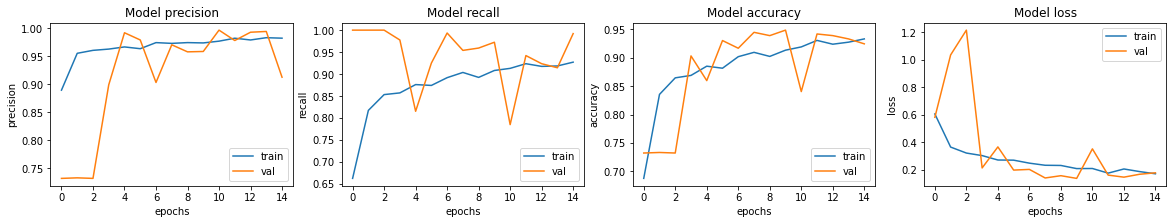

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

42/42 [==============================] - 4s 104ms/step - loss: 1.1216 - accuracy: 0.7099 - precision: 0.6843 - recall: 0.9949
Loss: 1.1215531826019287,
Accuracy: 0.7099359035491943,
Precision: 0.684303343296051,
Recall: 0.9948717951774597


# 3. 모델 구조 변경하여 베이스 모델과의 성능 비교

In [29]:
# BatchNormalization을 빼고 Dropout을 추가해보았어요.
import tensorflow as tf

def conv_block(filters, dropout_rate=0.2):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),  # 3x3 conv2D 1개 추가
        tf.keras.layers.Dropout(dropout_rate),  # Dropout 추가, 정규화 제거
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def conv_block(filters, dropout_rate=0.2):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(dropout_rate),  # Dropout 추가, 정규화 제거
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)  # BatchNormalization 대신 Dropout 사용
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128, dropout_rate=0.3),  # dropout rate 변경 가능
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256, dropout_rate=0.4),  # dropout rate 변경 가능
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 클래스 가중치 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
279/279 [==============================] - 63s 192ms/step - loss: 0.6942 - accuracy: 0.4918 - precision: 0.7429 - recall: 0.4851 - val_loss: 0.6941 - val_accuracy: 0.2647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
279/279 [==============================] - 53s 191ms/step - loss: 0.6937 - accuracy: 0.4337 - precision: 0.7498 - recall: 0.3589 - val_loss: 0.6863 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 3/15
279/279 [==============================] - 53s 191ms/step - loss: 0.6935 - accuracy: 0.5888 - precision: 0.7459 - recall: 0.6787 - val_loss: 0.7005 - val_accuracy: 0.2686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
279/279 [==============================] - 53s 192ms/step - loss: 0.6936 - accuracy: 0.5130 - precision: 0.7407 - recall: 0.5319 - val_loss: 0.7044 - val_accuracy: 0.2638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
279/279 [==============================] - 54s 195ms/step

### 배치정규화를 Dropout으로 바꿨더니 정확도가 형편없어짐...
- 역시 많이 하는데에는 이유가 있다.
- 정규화와 Dropout을 같이 적용하지 않는다고 글을 봤는데, 그 이유를 찾아봐야겠다.


# 4. Resnet-18 모델을 구현하고 학습 성공

In [122]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory  # 모듈 임포트
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수, Resnet은 224,224,3이라고해서 여기서부터 수정해봄
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# Epoch, Batch_size 15회
BATCH_SIZE = 15
EPOCHS = 15

print(ROOT_PATH)

# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드 활용
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# train 데이터 셋과 validation 데이터 셋을 만듭니다.
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줍니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터 갯수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# Data Augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.    
    image = tf.image.random_flip_up_down(image) # 랜덤하게 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3)     # 랜덤하게 밝기 조정    
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)     # 랜덤하게 대비 조정
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # 복잡한 augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

/aiffel/aiffel
Training images count: 4185
Validating images count: 1047


In [123]:
# Residual Block 정의
def residual_block(input_tensor, filters, stride=1):
    # 첫 번째 3x3 Conv layer
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 3x3 Conv layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), strides=stride, use_bias=False)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    
    return x

# ResNet-18 모델 정의
def ResNet18(input_shape=(224, 224, 3), num_classes=1): 
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv layer와 MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual Block들을 쌓아올림
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global Average Pooling 및 Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x) #softmax에서 sigmoid로 변경

    # 모델 생성
    model = models.Model(inputs, outputs)
    return model

# 모델 생성 및 확인
model = ResNet18(input_shape=(224, 224, 3), num_classes=1) # classes 1000 -> 1로 수정
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_286 (Conv2D)             (None, 112, 112, 64) 9408        input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_287 (BatchN (None, 112, 112, 64) 256         conv2d_286[0][0]                 
__________________________________________________________________________________________________
re_lu_238 (ReLU)                (None, 112, 112, 64) 0           batch_normalization_287[0][0]    
___________________________________________________________________________________________

In [124]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

Image shape:  (224, 224, 3)
Label:  False
624


In [127]:
# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),  # 이진 분류의 경우
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


In [129]:
# 데이터를 배치 단위로 준비하는 부분
train_ds = prepare_for_training(train_ds)  # 이미 배치 적용된 부분 유지
val_ds = prepare_for_training(val_ds)      # 이미 배치 적용된 부분 유지
test_ds = test_ds.batch(BATCH_SIZE)        # 배치 추가

# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        steps_per_epoch=train_steps,        # 한 에포크당 훈련할 스텝 수
        validation_steps=val_steps          # 한 에포크당 검증할 스텝 수
    )


Epoch 1/10
279/279 [==============================] - 138s 200ms/step - loss: 0.4832 - accuracy: 0.7981 - precision: 0.8398 - recall: 0.9005 - val_loss: 3.2688 - val_accuracy: 0.7353 - val_precision: 0.7350 - val_recall: 1.0000
Epoch 2/10
279/279 [==============================] - 56s 202ms/step - loss: 0.2716 - accuracy: 0.8846 - precision: 0.9115 - recall: 0.9358 - val_loss: 1.0192 - val_accuracy: 0.7372 - val_precision: 0.7357 - val_recall: 1.0000
Epoch 3/10
279/279 [==============================] - 57s 205ms/step - loss: 0.2298 - accuracy: 0.9085 - precision: 0.9323 - recall: 0.9457 - val_loss: 0.4342 - val_accuracy: 0.8483 - val_precision: 0.8337 - val_recall: 0.9908
Epoch 4/10
279/279 [==============================] - 57s 204ms/step - loss: 0.1853 - accuracy: 0.9302 - precision: 0.9508 - recall: 0.9557 - val_loss: 0.2475 - val_accuracy: 0.8812 - val_precision: 0.9185 - val_recall: 0.9197
Epoch 5/10
279/279 [==============================] - 57s 203ms/step - loss: 0.1748 - accur

- 성능 괜찮게 나왔습니다.
- Recall은 0.71정도로, 어느정도가 적정한지 모르겠습니다.
- 의료데이터가 Recall 항목이 중요하다고 글을 봤는데 그 이유를 찾아봐야겠습니다.